In [4]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, kruskal


In [15]:
#Read Data

# Physiological data
physiological_df = pd.read_csv(
    "combined_output.csv",
    low_memory=False
)

# Activity labels 
activity_df = pd.read_excel("updated_activity_labels_2.xlsx")


In [16]:
#Quick sanity check

print(physiological_df.head())
print(activity_df.head())

print(physiological_df.columns)
print(activity_df.columns)


                   timestamp user    ECG Accelerometer_X Accelerometer_Y  \
0  2023-08-09 09:16:42+00:00    1  0.018        -295.104         -11.561   
1  2023-08-09 09:16:43+00:00    1  0.029        -289.318         -12.666   
2  2023-08-09 09:16:44+00:00    1  0.028        -289.527          -8.734   
3  2023-08-09 09:16:45+00:00    1  0.024        -291.045          -8.093   
4  2023-08-09 09:16:46+00:00    1   0.02        -270.918           6.211   

  Accelerometer_Z Marker      HRV  
0        -905.376    0.0  -16.059  
1         -909.46    0.0  350.336  
2        -909.541    0.0  227.084  
3        -908.504    0.0   211.71  
4        -917.384    0.0  122.782  
   sampling_id       date  activity_number         description  intensity  \
0            1 2023-08-09                1     At the computer        0.0   
1            1 2023-08-09                2            Scooting        1.0   
2            1 2023-08-09                3  Walking and stairs        1.0   
3            1 2023

In [20]:
activity_df = activity_df.copy()

# Ensure date is a datetime date
activity_df["date"] = pd.to_datetime(activity_df["date"]).dt.date

# Convert time_of_day to a consistent HH:MM string
# 1) coerce to string
tod = activity_df["time_of_day"].astype(str).str.strip()

# 2) if it's like '11:30:00', keep only HH:MM - this is a cleaned version of the time_of_day column
tod = tod.str.slice(0, 5)

activity_df["start_time"] = pd.to_datetime(
    activity_df["date"].astype(str) + " " + tod,
    format="%Y-%m-%d %H:%M",
    errors="coerce"
)

# Create end_time using minutes column
activity_df["end_time"] = activity_df["start_time"] + pd.to_timedelta(activity_df["minutes"], unit="m") #Creates end_time column by 
#calculating the duration of each activity based on the start_time and the minutes column.

# 1) Force to string and remove obvious junk header rows
physiological_df["timestamp"] = physiological_df["timestamp"].astype(str).str.strip()

# Drop rows where timestamp is literally the header or blank
physiological_df = physiological_df[~physiological_df["timestamp"].isin(["timestamp", "nan", "NaN", ""])]


# 2) Parse with robust settings
physiological_df["timestamp"] = pd.to_datetime(
    physiological_df["timestamp"],
    utc=True,
    errors="coerce",
    format="mixed"   # handles "2023-08-09 09:16:42+00:00" and other ISO variations
).dt.tz_convert(None)

# 3) Drop any rows that still failed parsing
physiological_df = physiological_df.dropna(subset=["timestamp"])


physiological_df["timestamp"] = pd.to_datetime(
    physiological_df["timestamp"],
    utc=True
).dt.tz_convert(None)

print("Physio:", physiological_df["timestamp"].min(), "→", physiological_df["timestamp"].max())
print("Activity:", activity_df["start_time"].min(), "→", activity_df["end_time"].max())


# Sanity check - check that all the correct columns are there
print("Physiological DF columns:")
for c in physiological_df.columns:
    print("  -", c)

print("\nActivity DF columns:")
for c in activity_df.columns:
    print("  -", c)


Physio: 2023-08-09 09:16:42 → 2025-02-05 15:38:01
Activity: 2023-08-09 08:57:00 → 2024-11-12 23:00:00
Physiological DF columns:
  - timestamp
  - user
  - ECG
  - Accelerometer_X
  - Accelerometer_Y
  - Accelerometer_Z
  - Marker
  - HRV

Activity DF columns:
  - sampling_id
  - date
  - activity_number
  - description
  - intensity
  - minutes
  - time_of_day
  - activity_label
  - start_time
  - end_time


In [34]:
set(physiological_df["user"].unique()) & set(activity_df["sampling_id"].unique()) #Check for common users between physiological and activity data


{np.int64(1),
 np.int64(2),
 np.int64(3),
 np.int64(4),
 np.int64(6),
 np.int64(7),
 np.int64(9),
 np.int64(10),
 np.int64(11),
 np.int64(12),
 np.int64(13),
 np.int64(14),
 np.int64(15),
 np.int64(17),
 np.int64(18)}

In [35]:
def assign_activity(ts, user_id, activity_df):
    match = activity_df[
        (activity_df["sampling_id"] == user_id) &
        (activity_df["start_time"] <= ts) &
        (activity_df["end_time"] > ts)
    ]
    if len(match) > 0:
        return match.iloc[0]["activity_label"]
    else:
        return np.nan


physiological_df["activity_label"] = physiological_df.apply(
        lambda row: assign_activity(
        row["timestamp"],
        row["user"],
        activity_df
    ),
    axis=1
)

physiological_df["activity_label"].value_counts(dropna=False)


KeyboardInterrupt: 

In [ ]:
physiological_df["activity_label"].notna().sum()
print("Physio:", physiological_df["timestamp"].min(), "→", physiological_df["timestamp"].max())
print("Activity:", activity_df["start_time"].min(), "→", activity_df["end_time"].max())

u = activity_df["sampling_id"].iloc[0]

a = activity_df[activity_df["sampling_id"] == u].sort_values("start_time")
p = physiological_df[physiological_df["user"] == u].sort_values("timestamp")

# Physio: user as int
physiological_df["user"] = pd.to_numeric(physiological_df["user"], errors="coerce")
physiological_df = physiological_df.dropna(subset=["user"])
physiological_df["user"] = physiological_df["user"].astype(int)

# Activity: sampling_id as int
activity_df["sampling_id"] = pd.to_numeric(activity_df["sampling_id"], errors="coerce")
activity_df = activity_df.dropna(subset=["sampling_id"])
activity_df["sampling_id"] = activity_df["sampling_id"].astype(int)

print("Rows where user==1:", (physiological_df["user"] == 1).sum())





Physio: 2023-08-09 09:16:42 → 2025-02-05 15:38:01
Activity: 2023-08-09 08:57:00 → 2024-11-12 23:00:00
Rows where user==1: 314286


In [ ]:

labelled_users = sorted(set(activity_df["sampling_id"].unique()) & set(physiological_df["user"].unique()))
print("Users with labels:", labelled_users)

out = []

for u in labelled_users:
    p = physiological_df[physiological_df["user"] == u].sort_values("timestamp").copy()
    a = activity_df[activity_df["sampling_id"] == u].sort_values("start_time").copy()

    m = pd.merge_asof(
        p,
        a[["start_time", "end_time", "activity_label"]],
        left_on="timestamp",
        right_on="start_time",
        direction="backward",
        allow_exact_matches=True
    )

    m["activity_label"] = np.where(
        m["timestamp"] < m["end_time"],
        m["activity_label"],
        np.nan
    )

    m = m.drop(columns=["start_time", "end_time"])
    out.append(m)

# Users without activity labels → keep them with NaN activity_label
unlabelled = physiological_df[~physiological_df["user"].isin(labelled_users)].copy()
unlabelled["activity_label"] = np.nan

physiological_labelled = pd.concat(out + [unlabelled], ignore_index=True)


Users with labels: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(6), np.int64(7), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(17), np.int64(18)]


KeyError: 'activity_label'

In [ ]:
import numpy as np
import pandas as pd

# Tripwire: confirm columns at the moment you run this
print("Top-level activity_df columns:", list(activity_df.columns))

labelled_users = sorted(set(activity_df["sampling_id"].unique()) & set(physiological_df["user"].unique()))
print("Users with labels:", labelled_users)

out = []

for u in labelled_users:
    p = physiological_df[physiological_df["user"] == u].sort_values("timestamp").copy()
    a = activity_df[activity_df["sampling_id"] == u].sort_values("start_time").copy()

    # Tripwire: prove the subset 'a' has the column right before selecting
    if "activity_label" not in a.columns:
        print("DEBUG u =", u)
        print("type(a) =", type(a))
        print("a.columns =", list(a.columns))
        raise KeyError("activity_label missing in subset 'a'")

    m = pd.merge_asof(
        p,
        a.loc[:, ["start_time", "end_time", "activity_label"]],
        left_on="timestamp",
        right_on="start_time",
        direction="backward",
        allow_exact_matches=True
    )

    m["activity_label"] = np.where(m["timestamp"] < m["end_time"], m["activity_label"], np.nan)
    out.append(m.drop(columns=["start_time", "end_time"]))

unlabelled = physiological_df[~physiological_df["user"].isin(labelled_users)].copy()
unlabelled["activity_label"] = np.nan

physiological_labelled = pd.concat(out + [unlabelled], ignore_index=True)


Top-level activity_df columns: ['sampling_id', 'date', 'activity_number', 'description', 'intensity', 'minutes', 'time_of_day', 'activity_label', 'start_time', 'end_time']
Users with labels: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(6), np.int64(7), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(17), np.int64(18)]


KeyError: 'activity_label'

In [36]:
import numpy as np
import pandas as pd

# --- 0) Safety: remove any old label column from previous attempts ---
if "activity_label" in physiological_df.columns:
    physiological_df = physiological_df.drop(columns=["activity_label"])

# --- 1) Ensure IDs are ints (critical) ---
physiological_df["user"] = pd.to_numeric(physiological_df["user"], errors="coerce")
physiological_df = physiological_df.dropna(subset=["user"])
physiological_df["user"] = physiological_df["user"].astype(int)

activity_df["sampling_id"] = pd.to_numeric(activity_df["sampling_id"], errors="coerce")
activity_df = activity_df.dropna(subset=["sampling_id"])
activity_df["sampling_id"] = activity_df["sampling_id"].astype(int)

# --- 2) Make sure timestamps are datetime and tz-naive ---
# (skip if already done, but safe to re-run)
physiological_df["timestamp"] = pd.to_datetime(physiological_df["timestamp"], utc=True, errors="coerce").dt.tz_convert(None)
physiological_df = physiological_df.dropna(subset=["timestamp"])

activity_df["start_time"] = pd.to_datetime(activity_df["start_time"], errors="coerce")
activity_df["end_time"]   = pd.to_datetime(activity_df["end_time"], errors="coerce")
activity_df = activity_df.dropna(subset=["start_time", "end_time"])

# --- 3) Users that actually have labels ---
labelled_users = sorted(set(activity_df["sampling_id"].unique()) & set(physiological_df["user"].unique()))
print("Users with labels:", labelled_users)

out = []

for u in labelled_users:
    p = physiological_df.loc[physiological_df["user"] == u].sort_values("timestamp").copy()
    a = activity_df.loc[activity_df["sampling_id"] == u].sort_values("start_time").copy()

    # merge_asof needs the merge keys sorted (they are, within each user)
    m = pd.merge_asof(
        p,
        a[["start_time", "end_time", "activity_label"]],
        left_on="timestamp",
        right_on="start_time",
        direction="backward",
        allow_exact_matches=True
    )

    # Only keep label if within the interval
    m["activity_label"] = np.where(m["timestamp"] < m["end_time"], m["activity_label"], np.nan)

    # Drop interval columns
    m = m.drop(columns=["start_time", "end_time"])
    out.append(m)

# Users without labels: keep them, label stays NaN
unlabelled = physiological_df.loc[~physiological_df["user"].isin(labelled_users)].copy()
unlabelled["activity_label"] = np.nan

physiological_labelled = pd.concat(out + [unlabelled], ignore_index=True)

print("Non-NaN labels:", physiological_labelled["activity_label"].notna().sum())
physiological_labelled["activity_label"].value_counts(dropna=False).head(20)


Users with labels: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(6), np.int64(7), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(17), np.int64(18)]
Non-NaN labels: 1610647


activity_label
NaN                  3043886
sit                   848147
lying                 261600
stand                 249916
light_activity        203764
moderate_activity      47220
Name: count, dtype: int64

In [37]:
# pick a labelled user and look at 20 rows
u = labelled_users[0]
physiological_labelled.loc[physiological_labelled["user"] == u, ["timestamp", "activity_label"]].head(40)


,timestamp,activity_label
0,2023-08-09 09:16:42,light_activity
1,2023-08-09 09:16:42,light_activity
2,2023-08-09 09:16:42,light_activity
3,2023-08-09 09:16:43,light_activity
4,2023-08-09 09:16:43,light_activity
5,2023-08-09 09:16:43,light_activity
6,2023-08-09 09:16:44,light_activity
7,2023-08-09 09:16:44,light_activity
8,2023-08-09 09:16:44,light_activity
9,2023-08-09 09:16:45,light_activity


In [43]:
physiological_labelled["activity_label"].value_counts().head(10)
total = len(physiological_labelled)
labelled = physiological_labelled["activity_label"].notna().sum()

print(f"{labelled:,} / {total:,} rows labelled ({labelled/total:.1%})")

physiological_labelled.to_csv(
    "physiological_with_activity_labels.csv",
    index=False
)

physiological_labelled["activity_label"].value_counts()
physiological_labelled["activity_label"].value_counts(dropna=False)





1,610,647 / 4,654,533 rows labelled (34.6%)


activity_label
NaN                  3043886
sit                   848147
lying                 261600
stand                 249916
light_activity        203764
moderate_activity      47220
Name: count, dtype: int64

In [63]:
df = physiological_labelled.copy()

num_cols = ["HRV", "ECG", "Accelerometer_X", "Accelerometer_Y", "Accelerometer_Z"]
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Optional: drop rows missing any key numeric signal for stats
df = df.dropna(subset=["HRV", "ECG", "Accelerometer_X", "Accelerometer_Y", "Accelerometer_Z"])

df[num_cols].dtypes


HRV                float64
ECG                float64
Accelerometer_X    float64
Accelerometer_Y    float64
Accelerometer_Z    float64
dtype: object

In [ ]:
#This takes the aggregation of physiological metrics grouped by user and activity label.
agg = (
    df.dropna(subset=["activity_label"])
      .groupby(["user", "activity_label"])
      .agg(
          HRV_mean=("HRV", "mean"),
          HRV_median=("HRV", "median"),
          ECG_std=("ECG", "std"),
          acc_x_std=("Accelerometer_X", "std"),
          acc_y_std=("Accelerometer_Y", "std"),
          acc_z_std=("Accelerometer_Z", "std"),
          n_samples=("HRV", "size"),
      )
      .reset_index()
)


# How many user-activity groups do we have?
print(agg.shape)

# How many groups per activity label?
print(agg["activity_label"].value_counts())

# See the distribution of sample sizes per group (helps you spot tiny unreliable groups)
print(agg["n_samples"].describe())

print(agg.head())




(52, 9)
activity_label
sit                  14
light_activity       13
stand                12
lying                 8
moderate_activity     5
Name: count, dtype: int64
count        52.000000
mean      30973.980769
std       34089.752724
min        1920.000000
25%        7170.000000
50%       18000.000000
75%       39073.500000
max      149760.000000
Name: n_samples, dtype: float64
   user  activity_label    HRV_mean  HRV_median   ECG_std   acc_x_std  \
0     1  light_activity  199.991360    203.9945  0.000821  509.006368   
1     1           lying  199.999367    195.5315  0.000189  478.660348   
2     1             sit  200.000929    198.8730  0.000420  368.421181   
3     1           stand  200.016751    205.5745  0.000567   68.439089   
4     3  light_activity  199.977913    200.0255  0.000705   84.041736   

    acc_y_std   acc_z_std  n_samples  
0  100.678759  300.953230      41094  
1  256.639773  525.933400      21600  
2  184.050440  369.563057      81000  
3  113.975667  223.0

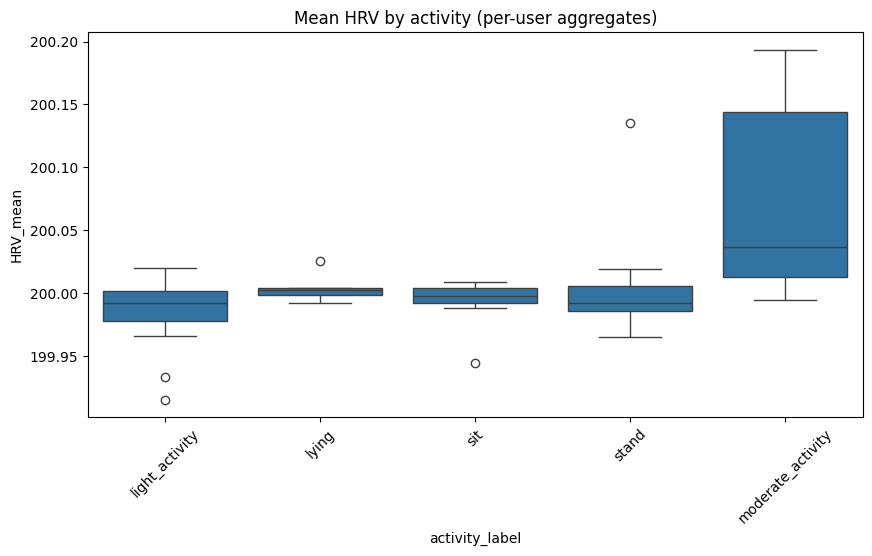

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
sns.boxplot(data=agg, x="activity_label", y="HRV_mean")
plt.xticks(rotation=45)
plt.title("Mean HRV by activity (per-user aggregates)")
plt.show()


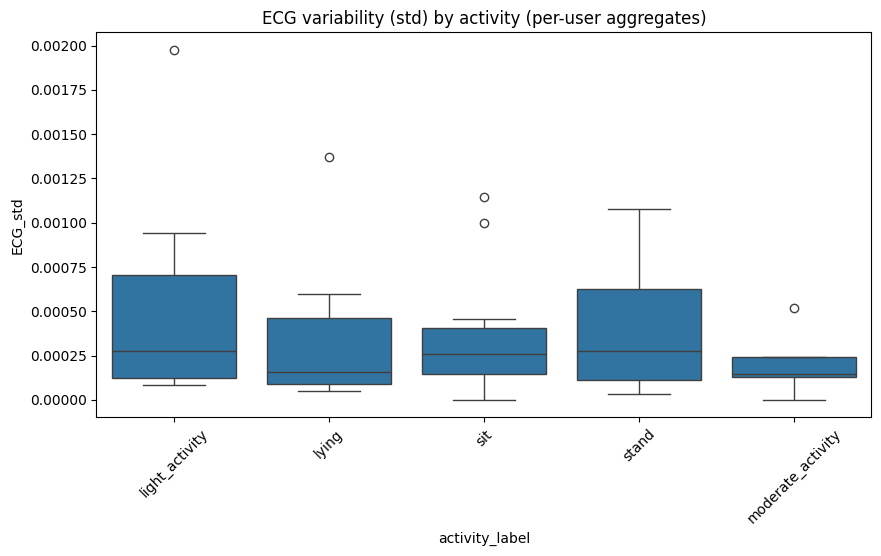

In [51]:
plt.figure(figsize=(10,5))
sns.boxplot(data=agg, x="activity_label", y="ECG_std")
plt.xticks(rotation=45)
plt.title("ECG variability (std) by activity (per-user aggregates)")
plt.show()


In [53]:
from scipy.stats import kruskal

labels = agg["activity_label"].unique()
groups = [agg.loc[agg["activity_label"] == lab, "HRV_mean"].dropna() for lab in labels]

stat, p = kruskal(*groups)
print("Kruskal–Wallis on HRV_mean across activities")
print("H =", stat, "p =", p)


groups_ecg = [
    agg.loc[agg["activity_label"] == label, "ECG_std"]
    for label in agg["activity_label"].unique()
]

H_ecg, p_ecg = kruskal(*groups_ecg)

print("Kruskal–Wallis on ECG_std across activities")
print("H =", H_ecg, "p =", p_ecg)



Kruskal–Wallis on HRV_mean across activities
H = 9.631561508158 p = 0.047113028077619856
Kruskal–Wallis on ECG_std across activities
H = 1.6936854351624773 p = 0.7918643511763915


In [58]:
%pip install scikit-posthocs seaborn

import scikit_posthocs as sp

# Use your per-user aggregated table
df_posthoc = agg.dropna(subset=["HRV_mean", "activity_label"]).copy()

# (Optional) Only keep labels with enough groups to be meaningful
counts = df_posthoc["activity_label"].value_counts()
keep = counts[counts >= 3].index
df_posthoc = df_posthoc[df_posthoc["activity_label"].isin(keep)]

# Dunn post-hoc for Kruskal–Wallis
pvals_holm = sp.posthoc_dunn(
    df_posthoc,
    val_col="HRV_mean",
    group_col="activity_label",
    p_adjust="holm"
)

print("Dunn post-hoc p-values (Holm):")
display(pvals_holm)


def pval_matrix_to_pairs(pmat, alpha=0.05):
    pairs = []
    for i in pmat.index:
        for j in pmat.columns:
            if i < j:  # avoid duplicates
                p = pmat.loc[i, j]
                if pd.notna(p) and p < alpha:
                    pairs.append((i, j, p))
    return pd.DataFrame(pairs, columns=["group_a", "group_b", "p_adj"]).sort_values("p_adj")

sig_holm = pval_matrix_to_pairs(pvals_holm, alpha=0.05)

print("Significant pairs (Holm):")
display(sig_holm)


Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Dunn post-hoc p-values (Holm):


,light_activity,lying,moderate_activity,sit,stand
light_activity,1.000000,0.75883,0.044082,1.000000,1.000000
lying,0.758830,1.00000,1.000000,1.000000,1.000000
moderate_activity,0.044082,1.00000,1.000000,0.200733,0.112434
sit,1.000000,1.00000,0.200733,1.000000,1.000000
stand,1.000000,1.00000,0.112434,1.000000,1.000000


Significant pairs (Holm):


,group_a,group_b,p_adj
0,light_activity,moderate_activity,0.044082


In [66]:
from scipy.stats import kruskal
import numpy as np

# -----------------------------
# 1) Create a single accelerometer variability metric (recommended)
# -----------------------------
# Combine axis standard deviations into one magnitude of variability.
# This is orientation-agnostic and easier to interpret than separate axes.
agg = agg.copy()
agg["acc_std_mag"] = np.sqrt(
    agg["acc_x_std"]**2 + agg["acc_y_std"]**2 + agg["acc_z_std"]**2
)

# Quick check
print("Accelerometer summary (acc_std_mag):")
print(agg["acc_std_mag"].describe())

# -----------------------------
# 2) Kruskal–Wallis tests for accelerometer features across activities
# -----------------------------
labels = agg["activity_label"].dropna().unique()

def kw_test(feature_col):
    groups = [
        agg.loc[agg["activity_label"] == lab, feature_col].dropna()
        for lab in labels
    ]
    H, p = kruskal(*groups)
    return H, p

for feat in ["acc_x_std", "acc_y_std", "acc_z_std", "acc_std_mag"]:
    H, p = kw_test(feat)
    print(f"Kruskal–Wallis on {feat} across activities: H = {H:.4f}, p = {p:.6g}")


Accelerometer summary (acc_std_mag):
count     52.000000
mean     391.944278
std      180.685485
min       23.296588
25%      258.492124
50%      376.345768
75%      484.027003
max      896.693719
Name: acc_std_mag, dtype: float64
Kruskal–Wallis on acc_x_std across activities: H = 11.1391, p = 0.0250443
Kruskal–Wallis on acc_y_std across activities: H = 7.1990, p = 0.125739
Kruskal–Wallis on acc_z_std across activities: H = 6.2674, p = 0.180048
Kruskal–Wallis on acc_std_mag across activities: H = 10.6727, p = 0.0304991


In [68]:
import scikit_posthocs as sp
import pandas as pd

# Prepare data (same structure as HRV post-hoc)
df_posthoc_acc = agg.dropna(subset=["acc_std_mag", "activity_label"]).copy()

# Dunn post-hoc for Kruskal–Wallis (Holm correction)
pvals_holm_acc = sp.posthoc_dunn(
    df_posthoc_acc,
    val_col="acc_std_mag",
    group_col="activity_label",
    p_adjust="holm"
)

print("Dunn post-hoc p-values for acc_std_mag (Holm):")
display(pvals_holm_acc)

def pval_matrix_to_pairs(pmat, alpha=0.05):
    pairs = []
    for i in pmat.index:
        for j in pmat.columns:
            if i < j:  # avoid duplicates
                p = pmat.loc[i, j]
                if pd.notna(p) and p < alpha:
                    pairs.append((i, j, p))
    return pd.DataFrame(
        pairs,
        columns=["group_a", "group_b", "p_adj"]
    ).sort_values("p_adj")

sig_holm_acc = pval_matrix_to_pairs(pvals_holm_acc, alpha=0.05)

print("Significant accelerometer pairs (Holm):")
display(sig_holm_acc)



Dunn post-hoc p-values for acc_std_mag (Holm):


,light_activity,lying,moderate_activity,sit,stand
light_activity,1.000000,1.000000,0.180206,1.000000,1.000000
lying,1.000000,1.000000,0.017596,1.000000,1.000000
moderate_activity,0.180206,0.017596,1.000000,0.051277,0.140793
sit,1.000000,1.000000,0.051277,1.000000,1.000000
stand,1.000000,1.000000,0.140793,1.000000,1.000000


Significant accelerometer pairs (Holm):


,group_a,group_b,p_adj
0,lying,moderate_activity,0.017596


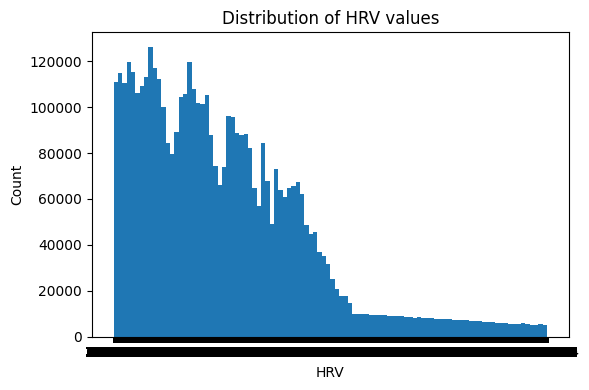

In [60]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.hist(physiological_df["HRV"], bins=100)
plt.xlabel("HRV")
plt.ylabel("Count")
plt.title("Distribution of HRV values")
plt.tight_layout()
plt.show()
